In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv') #
test = pd.read_csv('/kaggle/input/titanic/test.csv')
submit = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None # omit warnings

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info() # Age, Cabin, Embarked are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info() # Age, Fare, Cabin are missing -> Age, Fare, Cabin, Embarked are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Combine Train and Test Data****

In [9]:
data = train.append(test)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [10]:
data.reset_index(inplace=True, drop=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Data Analysis****

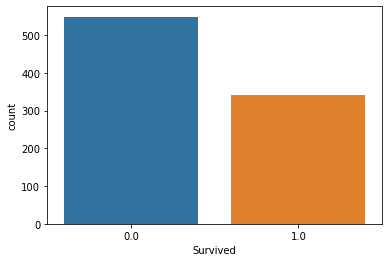

In [11]:
sns.countplot(data['Survived']) # Survived < No Survived

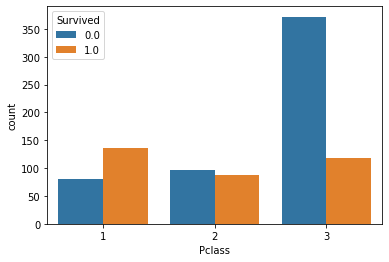

In [12]:
sns.countplot(data['Pclass'], hue= data['Survived']) # the ratio of Survived is decreasing from Pclass 1 to 3

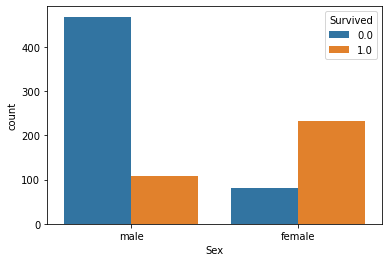

In [13]:
sns.countplot(data['Sex'], hue=data['Survived']) # the ratio of man's Survived < the ratio of female's Survived

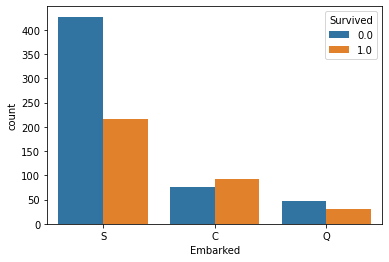

In [14]:
sns.countplot(data['Embarked'], hue=data['Survived']) # the number of Survived > the number of no Survived from the Embarked 'C'

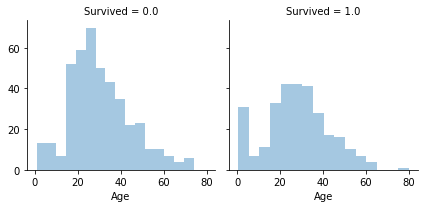

In [15]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Age', kde=False) # the Age is continuous variable, 5-15 is likely die

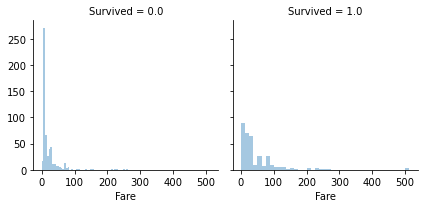

In [16]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fare', kde=False) 
# From the plots, the proportional of dying is hight if the Fare is low, 
# but the proportional of dying is low when the Fare is height.

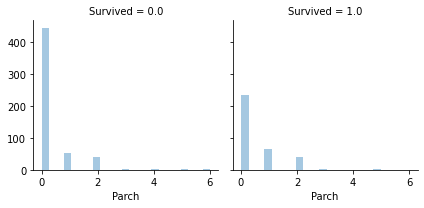

In [17]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Parch', kde=False) 
# From the plots, the proportional of dying is height if the Parch is low, 
# but the proportional of dying is low when the Parch is height.# 

In [18]:
data['Family_Size'] = data['Parch'] + data['SibSp'] # 

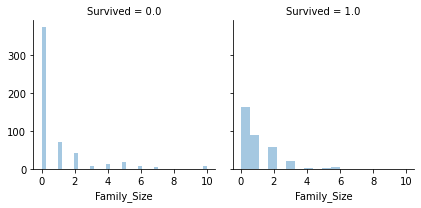

In [19]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Family_Size', kde=False)

# Feature Engineering****

In [20]:
data['Title1'] = data['Name'].str.split(", ", expand=True)[1] #

In [21]:
data['Title1']

0                                  Mr. Owen Harris
1       Mrs. John Bradley (Florence Briggs Thayer)
2                                      Miss. Laina
3               Mrs. Jacques Heath (Lily May Peel)
4                                Mr. William Henry
                           ...                    
1304                                     Mr. Woolf
1305                                 Dona. Fermina
1306                           Mr. Simon Sivertsen
1307                                 Mr. Frederick
1308                             Master. Michael J
Name: Title1, Length: 1309, dtype: object

In [22]:
# data['Title1'] = data['Name'].str.split(", ", expand=True)[1] #
data['Name'].str.split(", ", expand=True).head(3)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina


In [23]:
data['Title1'].head(3)

0                               Mr. Owen Harris
1    Mrs. John Bradley (Florence Briggs Thayer)
2                                   Miss. Laina
Name: Title1, dtype: object

In [24]:
data['Title1'] = data['Title1'].str.split(".", expand=True)[0]

In [25]:
data['Title1'].head(3)

0      Mr
1     Mrs
2    Miss
Name: Title1, dtype: object

In [26]:
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [27]:
pd.crosstab(data['Title1'],data['Sex']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [28]:
pd.crosstab(data['Title1'],data['Survived']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0.0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1.0,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


In [29]:
data.groupby(['Title1'])['Age'].mean()

Title1
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [30]:
data.groupby(['Title1','Pclass'])['Age'].mean() # 3 variables

Title1        Pclass
Capt          1         70.000000
Col           1         54.000000
Don           1         40.000000
Dona          1         39.000000
Dr            1         45.600000
              2         38.500000
Jonkheer      1         38.000000
Lady          1         48.000000
Major         1         48.500000
Master        1          6.984000
              2          2.757273
              3          6.090000
Miss          1         30.338983
              2         20.717083
              3         17.360874
Mlle          1         24.000000
Mme           1         24.000000
Mr            1         41.450758
              2         32.346715
              3         28.318910
Mrs           1         43.208955
              2         33.518519
              3         32.326531
Ms            2         28.000000
              3               NaN
Rev           2         41.250000
Sir           1         49.000000
the Countess  1         33.000000
Name: Age, dtype: float64

['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'], ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs',               'Mr','Mr',    'Mr','Mr','Mr',   'Mr','Mrs'

In [31]:
data['Title2'] = data['Title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
         ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs']) # reduce the category number

In [32]:
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [33]:
data.groupby('Title2')['Age'].mean()

Title2
Master     5.482642
Miss      21.824366
Mr        32.811056
Mrs       36.971264
Name: Age, dtype: float64

In [34]:
data.groupby(['Title2','Pclass'])['Age'].mean()

Title2  Pclass
Master  1          6.984000
        2          2.757273
        3          6.090000
Miss    1         30.131148
        2         20.865714
        3         17.360874
Mr      1         42.241497
        2         32.914966
        3         28.318910
Mrs     1         42.802817
        2         33.518519
        3         32.326531
Name: Age, dtype: float64

In [35]:
pd.crosstab(data['Title2'],data['Sex']).T.style.background_gradient(cmap='summer_r') # Checking the Initials with the Sex

Title2,Master,Miss,Mr,Mrs
Sex,,,,
female,0,264,1,201
male,61,0,782,0


In [36]:
pd.crosstab(data['Title2'],data['Survived']).T.style.background_gradient(cmap='summer_r') # Checking the Initials with the Sex

Title2,Master,Miss,Mr,Mrs
Survived,,,,
0.0,17,55,451,26
1.0,23,130,87,102


In [37]:
list(data.groupby(['Title2','Pclass'])['Age'].mean().iteritems())[:3]

[(('Master', 1), 6.984),
 (('Master', 2), 2.7572727272727273),
 (('Master', 3), 6.090000000000001)]

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Family_Size  1309 non-null   int64  
 13  Title1       1309 non-null   object 
 14  Title2       1309 non-null   object 
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


In [39]:
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] 
                                           if not x.isdigit() else 'X') 
# if x isn't digit, replace the symbal '. and / ' with blank 

In [40]:
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

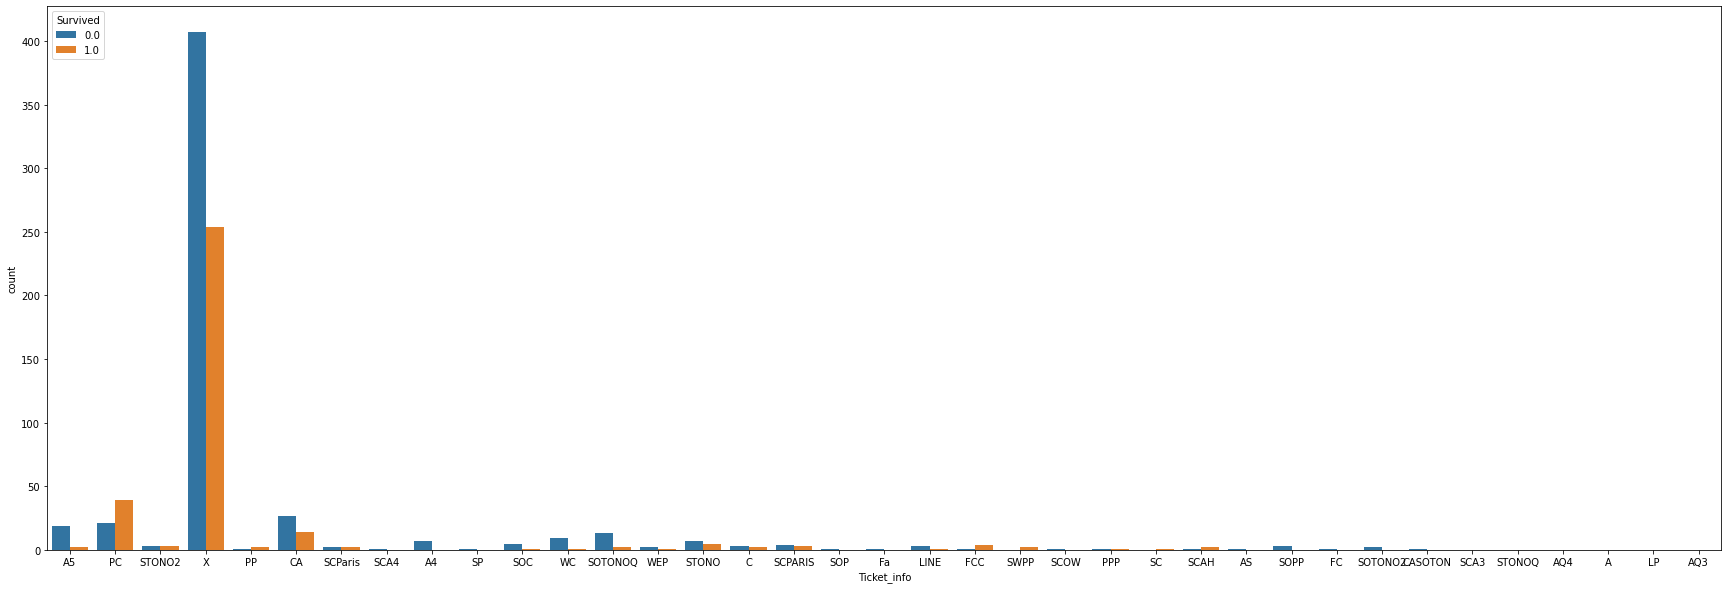

In [41]:
plt.figure(figsize=(30, 10))
sns.countplot(data['Ticket_info'], hue=data['Survived'])

# Missing Value-embarked、Fare、Age****

In [42]:
data['Embarked'] = data['Embarked'].fillna('S')

In [43]:
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())

In [44]:
data['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [45]:
data["Cabin"] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin') 
# Only the first English letters are taken out, and the rest are represented by NoCabin

In [46]:
data["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

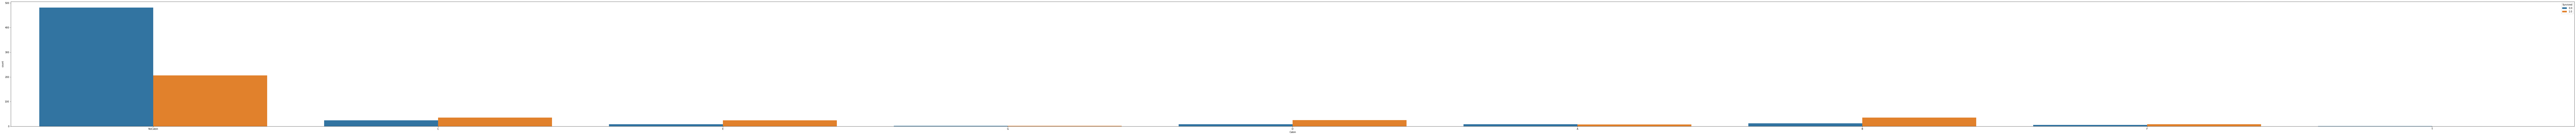

In [47]:
plt.figure(figsize=(200, 10))
sns.countplot(data['Cabin'], hue=data['Survived']) # can't display clear

In [48]:
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes # Pclass : int
# data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes

In [49]:
dataAgeNull = data[data["Age"].isnull()]
dataAgeNull

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
5,6,0.0,2,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,7,1,0,Mr,2,36
17,18,1.0,1,"Williams, Mr. Charles Eugene",1,NaN,0,0,244373,13.0000,7,2,0,Mr,2,36
19,20,1.0,2,"Masselmani, Mrs. Fatima",0,NaN,0,0,2649,7.2250,7,0,0,Mrs,3,36
26,27,0.0,2,"Emir, Mr. Farred Chehab",1,NaN,0,0,2631,7.2250,7,0,0,Mr,2,36
28,29,1.0,2,"O'Dwyer, Miss. Ellen ""Nellie""",0,NaN,0,0,330959,7.8792,7,1,0,Miss,1,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,2,"Riordan, Miss. Johanna Hannah""""",0,NaN,0,0,334915,7.7208,7,1,0,Miss,1,36
1301,1302,NaN,2,"Naughton, Miss. Hannah",0,NaN,0,0,365237,7.7500,7,1,0,Miss,1,36
1304,1305,NaN,2,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,7,2,0,Mr,2,2
1307,1308,NaN,2,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,7,2,0,Mr,2,36


In [50]:
dataAgeNotNull = data[data["Age"].notnull()]
dataAgeNotNull

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
0,1,0.0,2,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,2,1,Mr,2,2
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,1,Mrs,3,14
2,3,1.0,2,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,2,0,Miss,1,31
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1,Mrs,3,36
4,5,0.0,2,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,2,0,Mr,2,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1301,NaN,2,"Peacock, Miss. Treasteall",0,3.0,1,1,SOTON/O.Q. 3101315,13.7750,7,2,2,Miss,1,28
1302,1303,NaN,0,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,37.0,1,0,19928,90.0000,2,1,1,Mrs,3,36
1303,1304,NaN,2,"Henriksson, Miss. Jenny Lovisa",0,28.0,0,0,347086,7.7750,7,2,0,Miss,1,36
1305,1306,NaN,0,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,2,0,0,Dona,3,14


In [51]:

not_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())<(4*dataAgeNotNull["Fare"].std()))&
                      (np.abs(dataAgeNotNull["Family_Size"]-dataAgeNotNull["Family_Size"].mean())<(4*dataAgeNotNull["Family_Size"].std()))                     
                     ]

In [52]:
not_outlier

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
0,1,0.0,2,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,2,1,Mr,2,2
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,1,Mrs,3,14
2,3,1.0,2,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,2,0,Miss,1,31
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1,Mrs,3,36
4,5,0.0,2,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,2,0,Mr,2,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1301,NaN,2,"Peacock, Miss. Treasteall",0,3.0,1,1,SOTON/O.Q. 3101315,13.7750,7,2,2,Miss,1,28
1302,1303,NaN,0,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,37.0,1,0,19928,90.0000,2,1,1,Mrs,3,36
1303,1304,NaN,2,"Henriksson, Miss. Jenny Lovisa",0,28.0,0,0,347086,7.7750,7,2,0,Miss,1,36
1305,1306,NaN,0,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,2,0,0,Dona,3,14


In [53]:
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Sex', 'Fare', 'Title2', 'Pclass', 'Family_Size', 'Cabin', 'Ticket_info', 'Embarked']
rfModel_age.fit(not_outlier[ageColumns], not_outlier["Age"]) # ?

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
data = dataAgeNotNull.append(dataAgeNull)
data.reset_index(inplace=True, drop=True)

In [54]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
0,1,0.0,2,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,7,2,1,Mr,2,2
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,2,0,1,Mrs,3,14
2,3,1.0,2,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,7,2,0,Miss,1,31
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,2,2,1,Mrs,3,36
4,5,0.0,2,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,7,2,0,Mr,2,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1300,NaN,2,"Riordan, Miss. Johanna Hannah""""",0,20.975022,0,0,334915,7.7208,7,1,0,Miss,1,36
1305,1302,NaN,2,"Naughton, Miss. Hannah",0,26.220109,0,0,365237,7.7500,7,1,0,Miss,1,36
1306,1305,NaN,2,"Spector, Mr. Woolf",1,32.241773,0,0,A.5. 3236,8.0500,7,2,0,Mr,2,2
1307,1308,NaN,2,"Ware, Mr. Frederick",1,31.159743,0,0,359309,8.0500,7,2,0,Mr,2,36


In [55]:
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

In [56]:
dataTrain.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info'],
      dtype='object')

In [57]:
dataTrain = dataTrain[['Survived', 'Sex', 'Fare', 'Age', 'Title2', 'Pclass', 'Family_Size', 'Cabin', 'Ticket_info', 'Embarked']]
dataTest = dataTest[['Sex', 'Fare', 'Age', 'Title2', 'Pclass', 'Family_Size', 'Cabin', 'Ticket_info', 'Embarked']]

In [58]:
dataTrain

,Survived,Sex,Fare,Age,Title2,Pclass,Family_Size,Cabin,Ticket_info,Embarked
0,0.0,1,7.2500,22.000000,2,2,1,7,2,2
1,1.0,0,71.2833,38.000000,3,0,1,2,14,0
2,1.0,0,7.9250,26.000000,1,2,0,7,31,2
3,1.0,0,53.1000,35.000000,3,0,1,2,36,2
4,0.0,1,8.0500,35.000000,2,2,0,7,36,2
...,...,...,...,...,...,...,...,...,...,...
710,0.0,1,13.0000,27.000000,2,1,0,7,36,2
711,1.0,0,30.0000,19.000000,1,0,0,1,36,2
1222,0.0,0,23.4500,10.294841,1,2,3,7,34,2
712,1.0,1,30.0000,26.000000,2,0,0,2,36,0


# Model training****

In [59]:
# rf = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16, 20], "n_estimators": [50, 100, 400, 700, 1000]}
# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# gs = gs.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])

# print(gs.best_score_)
# print(gs.best_params_)

0.8406285072951739
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 50}


In [56]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=50,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8339


In [57]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
0,Sex,0.232103
1,Fare,0.176862
2,Age,0.163707
3,Title2,0.134182
4,Pclass,0.092415
5,Family_Size,0.069410
7,Cabin,0.063011
6,Ticket_info,0.042303
8,Embarked,0.026006


# Submit

In [58]:
rf_res =  rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv', index= False)

In [59]:
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
